In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import matplotlib.pyplot as plt
import re
import cv2


In [ ]:
# Opens the file and reads its data
def readFile (path):
    with open(path) as file:
        data = file.read()
    return data;


In [ ]:

# Read captions from the file Flickr8k.token.txt
data = readFile ("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

# Split the data into each line, to get a list of captions
captions = data.split('\n')

# Remove the last line since it is blank
captions = captions[:-1]


In [ ]:

print("Total number of caption = " + str(len(captions)))

Total number of caption = 40460


In [ ]:

print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
# Store the captions in a dictionary
# Each imageID will be mapped to a list of its captions

content = {}

for line in captions:
    imageID, caption = line.split('\t')

    imageID = imageID.split('.')[0]

    # If the imageID doesn't exist in the dictionary, create a blank entry
    if content.get(imageID) is None:
        content[imageID] = []

    # Append the current caption to the list of the corresponding image
    content[imageID].append(caption)

In [ ]:
print(content[captions[0].split('.')[0]])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


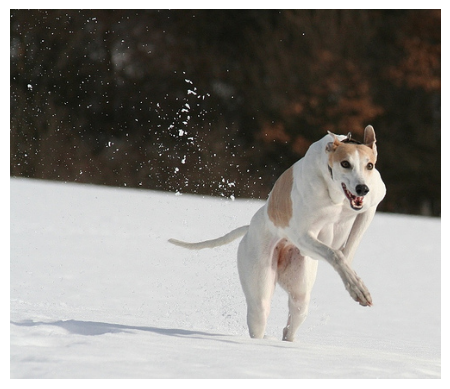

CAPTIONS - 
A brown and white dog is running through the snow .
A dog is running in the snow
A dog running through snow .
a white and brown dog is running through a snow covered field .
The white and brown dog is running over the surface of the snow .


In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_image_and_captions():
    # Choose a random number, say 50
    random_index = 50

    IMG_PATH = "/content/drive/MyDrive/Flickr_Data/Images/"
    image_id = captions[random_index].split('.')[0]

    # Load the image with error handling
    img = cv2.imread(IMG_PATH + image_id + ".jpg")
    if img is None:
        print("Error: Image not found or failed to load.")
        return  # Exit the function if the image cannot be loaded

    # Convert color space (if necessary)
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Print captions
    print("CAPTIONS - ")
    for caption in content[image_id]:
        print(caption)

# Call the function to execute the code
display_image_and_captions()



In [ ]:
def clean (data):
    # Convert all characters to lower case
    data = data.lower()

    # Convert all non-alphabet characters to ' '
    data = re.sub("[^a-z]+", " ", data)

    return data

In [ ]:

for ID, caption_list in content.items():
    for i in range(len(caption_list)):
        content[ID][i] = clean(content[ID][i])

In [ ]:

print(content[captions[50].split('.')[0]][-1])

the white and brown dog is running over the surface of the snow 


In [ ]:

with open ("/content/drive/MyDrive/Flickr_Data/tokens_clean.txt", "w") as file:
    file.write(str(content))

In [ ]:
import json
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle


In [ ]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("/content/drive/MyDrive/Flickr_Data/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)


In [ ]:
print(type(content))


<class 'dict'>


In [ ]:

#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [ ]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 8441


In [ ]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [ ]:
threshold = 5

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))


Number of common unique words = 2644


In [ ]:

# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt", 'r') as file:
    test_file_data = file.read()

In [ ]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [ ]:

train_data[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:

# For each imageID in train_data, store its captions in a dictionary

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [ ]:

train_content['1007320043_627395c3d8']

['startseq a child playing on a rope net  endseq',
 'startseq a little girl climbing on red roping  endseq',
 'startseq a little girl in pink climbs a rope bridge at the park  endseq',
 'startseq a small child grips onto the red ropes at the playground  endseq',
 'startseq the small child climbs on a red ropes on a playground  endseq']

In [ ]:
# Load VGG16 model pre-trained on ImageNet dataset
base_model = VGG16(weights='imagenet')
# Remove the last layer (output layer) of VGG16
base_model.layers.pop()

# Create a new model by combining VGG16 and a new input layer
new_input = Input(shape=(224, 224, 3))
feature_extractor = base_model(new_input)

# Add additional layers for processing image features
x = Dense(256, activation='relu')(feature_extractor)

# Create the feature extraction model
model_new = Model(inputs=new_input, outputs=x)

553467096/553467096 [==============================] - 25s 0us/step


In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

# Load VGG16 model pre-trained on ImageNet dataset
model = VGG16(weights='imagenet')

# Remove the last layer (output layer) from the model
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
import time

train_encoding = {}
# Create a dictionary of imageID and its feature vector
start_time = time.time()

for index, imageID in enumerate(train_data):
    image_path = "/content/drive/MyDrive/Flickr_Data/Images/" + imageID + ".jpg"
    train_encoding[imageID] = encode_image(image_path)
    if index % 100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time.time()  # Remove the extra time() call
print("Total time taken:", end_time - start_time, "sec")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
Encoding in progress... STEP 1100
1/1 [==============================] - 0s 21ms/step
Encoding in progress... STEP 1200
1/1 [==============================] - 0s 18ms/step
Encoding in progress... STEP 1300
1/1 [==============================] - 0s 18ms/step
Encoding in progress... STEP 1400
1/1 [==============================] - 0s 27ms/step
Encoding in progress... STEP 1500
1/1 [==============================] - 0s 19ms/step
Encoding in progress... STEP 1600
1/1 [==============================] - 0s 18ms/step
Encoding in progress... STEP 1700
1/1 [==============================] - 0s 18ms/step
Encoding in progress... STEP 1800
1/1 [==============================] - 0s 23ms/step
Encoding in progress... STEP 1900
1/1 [==============================] - 0s 17ms/step
Encoding in progress... STEP 2000
1/1 [==============================] - 0s 18ms/step
Encoding in progress... STEP 2100
1/1

In [ ]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
with open("/content/drive/MyDrive/Flickr_Data/encoded_train_features.pkl", "wb") as file:
    pickle.dump(train_encoding, file)

In [ ]:
import time

test_encoding = {}
# Create a dictionary of imageID and its feature vector
start_time = time.time()  # Correctly access the time() function

for index, imageID in enumerate(test_data):
    image_path = "/content/drive/MyDrive/Flickr_Data/Images/" + imageID + ".jpg"
    test_encoding[imageID] = encode_image(image_path)
    if index % 100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time.time()  # Correctly access the time() function
print("Total time taken:", end_time - start_time, "s")


1/1 [==============================] - 0s 20ms/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 18ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 22ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 22ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 22ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 19ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 18ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 18ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 20ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 19ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 17ms/step
Total time taken: 679.9215602874756 s


In [ ]:
with open("/content/drive/MyDrive/Flickr_Data/encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

In [ ]:
word_to_index = {}
index_to_word = {}
for i, word in enumerate(total_words):
    word_to_index[word] = i + 1
    index_to_word[i + 1] = word
    print(len(index_to_word))

print(index_to_word[5])
print(word_to_index['is'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
# Add startseq and endseq also to the mappings
index_to_word[2645] = 'startseq'
word_to_index['startseq'] = 2645

index_to_word[2646] = 'endseq'
word_to_index['endseq'] = 2646

VOCAB_SIZE = len(word_to_index) + 1

print(VOCAB_SIZE)

2647


In [ ]:
with open("/content/drive/MyDrive/Flickr_Data/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [ ]:
with open("/content/drive/MyDrive/Flickr_Data/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [ ]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

print(max_len)

38


In [ ]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/glove.6B.50d.txt", encoding='utf8')

# Create a mapping from word to embedding
word_to_embedding = {}

for line in file:
    values = line.split()

    word = values[0]
    embedding = np.array(values[1:], dtype='float')
    word_to_embedding[word] = embedding

file.close()

In [ ]:
word_to_embedding["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
EMBEDDING_DIM = 50
def get_embedding_matrix():
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

    for word, index in word_to_index.items():
        embedding = word_to_embedding.get(word)
        if embedding is not None:
            embedding_matrix[index] = embedding

    return embedding_matrix

index_to_embedding = get_embedding_matrix()
print(index_to_embedding.shape)

(2647, 50)


In [ ]:
inp_img_features = Input(shape=(4096,))
inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model(inputs=[inp_img_features, inp_cap], outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 38)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 38, 50)               132350    ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_1[0][0]']             
                                                                                              

In [ ]:
# Preinitialize Embedding layer
model.layers[2].set_weights([index_to_embedding])
model.layers[2].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam")

In [ ]:
# Define a data generator function
def data_generator(train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding[imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range(1, len(idx_seq)):
                    xi = idx_seq[0: i]  # The input sequence of words
                    yi = idx_seq[i]  # The next word after the above sequence (this is expected to be predicted)

                    # Add padding of zeros so lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n == batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]

                    X1, X2, y = [], [], []
                    n = 0

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_content) // batch_size

for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit_generator(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

In [ ]:
from google.colab import drive
import datetime
import os

# Mount Google Drive
drive.mount('/content/drive')

def save_model(model, i, save_dir="/content/drive/MyDrive/Flickr_Data/check_points/"):

    # Ensure save directory exists and is writable
    os.makedirs(save_dir, exist_ok=True)
    if not os.access(save_dir, os.W_OK):
        raise ValueError(f"Save directory '{save_dir}' is not writable")

    # Create a unique timestamp-based filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"model_{i}_{timestamp}.h5"
    filepath = os.path.join(save_dir, filename)

    # Save the model
    model.save(filepath)
    print(f"Model saved successfully to: {filepath}")

# Training loop with model saving
epochs = 20
batch_size = 3
steps = len(train_content) // batch_size

for i in range(epochs):
    # Create the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)

    # Train the model
    model.fit_generator(generator, steps_per_epoch=steps)

    # Save the model to the specified Drive directory
    save_model(model, i)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-51-65046825870c>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, steps_per_epoch=steps)


2000/2000 [==============================] - 38s 15ms/step - loss: 4.0561


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully to: /content/drive/MyDrive/Flickr_Data/check_points/model_0_20240206_110547.h5
2000/2000 [==============================] - 31s 15ms/step - loss: 3.3444
Model saved successfully to: /content/drive/MyDrive/Flickr_Data/check_points/model_1_20240206_110618.h5
2000/2000 [==============================] - 35s 17ms/step - loss: 3.1007
Model saved successfully to: /content/drive/MyDrive/Flickr_Data/check_points/model_2_20240206_110700.h5
2000/2000 [==============================] - 32s 16ms/step - loss: 2.9333
Model saved successfully to: /content/drive/MyDrive/Flickr_Data/check_points/model_3_20240206_110741.h5
2000/2000 [==============================] - 31s 16ms/step - loss: 2.8301
Model saved successfully to: /content/drive/MyDrive/Flickr_Data/check_points/model_4_20240206_110822.h5
2000/2000 [==============================] - 31s 16ms/step - loss: 2.7442
Model saved successfully to: /content/drive/MyDrive/Flickr_Data/check_points/model_5_20240206_110903.h5
2000/2

In [ ]:
pip install rouge


Loading the model...
Running model to generate the caption...
1/1 [==============================] - 0s 27ms/step


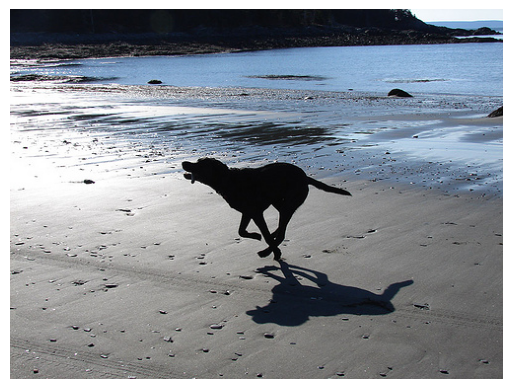

Generated Caption: a black dog is running on the beach
BLEU Score: 0.8091067115702212


AttributeError: 'list' object has no attribute 'split'

In [ ]:
import json
from keras.models import load_model
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import collections
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

# Read the files word_to_idx.pkl and idx_to_word.pkl to get the mapping between word and index
word_to_index = {}
with open("/content/drive/MyDrive/Flickr_Data/word_to_idx.pkl", 'rb') as file:
    word_to_index = pickle.load(file)

index_to_word = {}
with open("/content/drive/MyDrive/Flickr_Data/idx_to_word.pkl", 'rb') as file:
    index_to_word = pickle.load(file)

print("Loading the model...")
model = load_model('/content/drive/MyDrive/Flickr_Data/check_points/model_19_20240206_111720.h5')

test_encoding = {}
with open("/content/drive/MyDrive/Flickr_Data/encoded_test_features.pkl", "rb") as file:
    test_encoding = pickle.load(file)

# Generate Captions for a random image in test dataset
def predict_caption(photo):
    inp_text = "startseq"

    for i in range(38):
        sequence = [word_to_index[w] for w in inp_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=38, padding='post')

        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = index_to_word[ypred]

        inp_text += (' ' + word)

        if word == 'endseq':
            break

    final_caption = inp_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

all_img_IDs = list(test_encoding.keys())

# Get a random image
number = np.random.randint(0, len(test_encoding))
img_ID = all_img_IDs[int(number)]
photo = test_encoding[img_ID].reshape((1, 4096))  # Since VGG16 outputs 4096-dimensional features

print("Running model to generate the caption...")
generated_caption = predict_caption(photo)

img_data = plt.imread("/content/drive/MyDrive/Flickr_Data/Images/" + img_ID + ".jpg")
plt.imshow(img_data)
plt.axis("off")
plt.show()

print("Generated Caption:", generated_caption)
# Read reference captions from the dataset
reference_captions = [caption.split() for caption in content[img_ID]]
# Calculate BLEU score
BLEU_score = sentence_bleu(reference_captions, generated_caption.split())
print("BLEU Score:", BLEU_score)
# Flatten the list of lists into a single list of strings
reference_captions_flat = [' '.join(caption) for caption in reference_captions]


Loading the model...
Encoding the image ...
1/1 [==============================] - 0s 138ms/step
Running model to generate the caption...
1/1 [==============================] - 0s 18ms/step


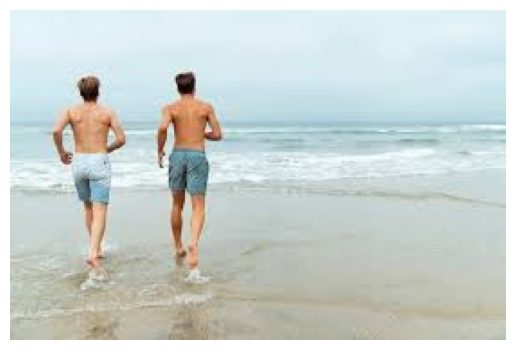

a young boy in a bathing suit is walking on the beach


In [ ]:
import json
from keras.models import load_model
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import collections
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

# Read the files word_to_idx.pkl and idx_to_word.pkl to get the mappings between word and index
word_to_index = {}
with open("/content/drive/MyDrive/Flickr_Data/word_to_idx.pkl", 'rb') as file:
    word_to_index = pd.read_pickle(file)

index_to_word = {}
with open("/content/drive/MyDrive/Flickr_Data/idx_to_word.pkl", 'rb') as file:
    index_to_word = pd.read_pickle(file)

print("Loading the model...")
model = load_model('/content/drive/MyDrive/Flickr_Data/check_points/model_19_20240206_111720.h5')

vgg16_model = VGG16(weights='imagenet', include_top=True)
vgg16_model = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('fc2').output)

# Generate Captions for a random image in test dataset
def predict_caption(photo):
    inp_text = "startseq"

    for i in range(38):
        sequence = [word_to_index[w] for w in inp_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=38, padding='post')

        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = index_to_word[ypred]

        inp_text += (' ' + word)

        if word == 'endseq':
            break

    final_caption = inp_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

def preprocess_image(img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tensor
    img = np.expand_dims(img, axis=0)

    # Normalize image according to VGG16 requirement
    img = preprocess_input(img)

    return img

# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image(img):
    img = preprocess_image(img)

    feature_vector = vgg16_model.predict(img)
    return feature_vector

print("Encoding the image ...")
img_name = "/content/drive/MyDrive/input1.jpg"
photo = encode_image(img_name).reshape((1, 4096))  # VGG16 output dimension is 4096

print("Running model to generate the caption...")
caption = predict_caption(photo)

img_data = plt.imread(img_name)
plt.imshow(img_data)
plt.axis("off")
plt.show()

print(caption)


In [ ]:
# ... your existing code upto model loading ...
import pandas as pd
test_encoding = {}
with open("/content/drive/MyDrive/Flickr_Data/encoded_test_features.pkl", "rb") as file:
    test_encoding = pd.read_pickle(file)

def predict_caption(photo):
    """Generates a caption for a given image."""
    inp_text = "startseq"

    for i in range(38):
        sequence = [word_to_index[w] for w in inp_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=38, padding='post')

        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = index_to_word[ypred]

        inp_text += (' ' + word)

        if word == 'endseq':
            break

    final_caption = inp_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

def calculate_bleu_score(reference_caption, generated_caption):
    """Calculates BLEU score between a reference and generated caption."""
    from nltk.translate.bleu_score import sentence_bleu
    return sentence_bleu([reference_caption.split()], generated_caption.split())

def evaluate_on_test_set():
    """Calculates and returns the average BLEU score on the test set."""
    total_bleu_score = 0
    num_images = len(test_encoding)

    for img_ID, reference_captions in content.items():
        if img_ID not in test_encoding:  # Skip images not in test set
            continue

        photo = test_encoding[img_ID].reshape((1,4096))
        generated_caption = predict_caption(photo)

        # Average BLEU if multiple references (choose a suitable method)
        reference_bleu_scores = [calculate_bleu_score(ref, generated_caption)
                                 for ref in reference_captions]
        average_bleu_score = sum(reference_bleu_scores) / len(reference_bleu_scores)

        total_bleu_score += average_bleu_score

    return total_bleu_score / num_images

average_bleu_score = evaluate_on_test_set()
print(f"Average BLEU score on test set: {average_bleu_score}")


1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
Average BLEU score on test set: 2.5115209753310067e-234
